In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torchsummary import summary
from torchmetrics.functional import accuracy

import os
from tqdm.notebook import tqdm
import pydub
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
learning_rate = 1e-4
eps = 1e-8
batch_size = 128
epochs = 20

# Load and prepare data

In [3]:
df = pd.read_csv('data/train_test_split.csv')

In [4]:
train_wav_list = np.concatenate([
    df['train_cat'].sample(64, random_state=2021).tolist(),
    df[~df['train_dog'].isnull()]['train_dog'].tolist()
])

In [5]:
test_wav_list = np.concatenate([
    df[~df['test_cat'].isnull()]['test_cat'].tolist(),
    df[~df['test_dog'].isnull()]['test_dog'].tolist()
])

In [6]:
class WavDataset(Dataset):
    def __init__(self, wave_list):
        super(WavDataset, self).__init__()
        self.wav_list = wave_list
        self.labels_index = {
            'cat': 0,
            'dog': 1
        }
        self.data_path = 'data/cats_dogs/'
        self.max_ms = 8000
        
    def __len__(self):
        return len(self.wav_list)
    
    def __getitem__(self, index):
        wav_file = self.wav_list[index]
        wav_file_path = os.path.join(self.data_path, wav_file)
        
        labels = self.labels_index[wav_file[:3]]
        sig, sr = torchaudio.load(wav_file_path)
        
        # Resample to 441khz
        resig = torchaudio.transforms.Resample(sr, 44100)(sig[:1, :])
        sr = 44100
        
        # Convert to 2 channel
        resig = torch.cat([resig, resig])
        
        # Pad trunc
        num_rows , sig_len = resig.shape
        max_len = sr // 1000 * self.max_ms
        
        if sig_len > max_len:
            resig = resig[:, :max_len]
        elif sig_len < max_len:
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = np.random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            resig = torch.cat((pad_begin, resig, pad_end), 1)
            
        # Convert to mel spectogram
        spec = torchaudio.transforms.MelSpectrogram(
            sr, n_fft=1024, hop_length=None, n_mels=64
        )(resig)
        spec = torchaudio.transforms.AmplitudeToDB(top_db=80)(spec)
        
        return spec, torch.tensor(labels)

In [7]:
train_dataset = WavDataset(train_wav_list)
test_dataset = WavDataset(test_wav_list)

In [8]:
train_sampler = RandomSampler(train_dataset)
test_sampler = SequentialSampler(test_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Build a simple model

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        self.flatten = nn.Flatten()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc1 = nn.Linear(128 * 1 * 1, 256)
        self.dropout = nn.Dropout(0.5)
        self.pred = nn.Linear(256, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pred(x)
        
        return x

In [10]:
model = SimpleCNN()
model.to('cuda')

SimpleCNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pred): Linear(in_features=256, out_features=2, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=eps)

In [12]:
summary(model, (2, 64, 430))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 62, 428]             608
              ReLU-2          [-1, 32, 62, 428]               0
         MaxPool2d-3          [-1, 32, 31, 214]               0
            Conv2d-4          [-1, 64, 29, 212]          18,496
              ReLU-5          [-1, 64, 29, 212]               0
         MaxPool2d-6          [-1, 64, 14, 106]               0
            Conv2d-7         [-1, 128, 12, 104]          73,856
              ReLU-8         [-1, 128, 12, 104]               0
         MaxPool2d-9           [-1, 128, 6, 52]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 256]          33,024
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

# Training Loop

In [13]:
train_loss = []
test_loss = []

for epoch in tqdm(range(epochs)):
    # Train
    model.train()
    running_loss = 0.0
    
    for index, (spec, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        batch_spec = spec.to('cuda')
        batch_label = label.to('cuda')
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch_spec)
        
        # Back pass
        loss = criterion(logits, batch_label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss/len(train_dataloader)))
        
    # Testing
    model.eval()
    y_true = []
    y_pred = []
    
    for index, (test_spec, test_label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        test_batch_spec = test_spec.to('cuda')
        test_batch_label = test_label.to('cuda')
        
        with torch.no_grad():
            test_logits = model(test_batch_spec)
        
        loss = criterion(test_logits, test_batch_label)
        test_loss.append(loss.item())
        
        y_true.append(test_batch_label.detach().cpu().numpy())
        y_pred.append(test_logits.detach().cpu().numpy())
        
    y_true, y_pred = torch.tensor(np.concatenate(y_true)), torch.tensor(np.concatenate(y_pred)).argmax(axis=1)
    
    print('Accuracy of the network on test images: %0.3f %%' % accuracy(y_true, y_pred))

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore



[Epoch 1] loss: 0.750



Accuracy of the network on test images: 0.663 %



[Epoch 2] loss: 0.741



Accuracy of the network on test images: 0.520 %



[Epoch 3] loss: 0.693



Accuracy of the network on test images: 0.510 %



[Epoch 4] loss: 0.715



Accuracy of the network on test images: 0.571 %



[Epoch 5] loss: 0.737



Accuracy of the network on test images: 0.653 %



[Epoch 6] loss: 0.687



Accuracy of the network on test images: 0.694 %



[Epoch 7] loss: 0.711



Accuracy of the network on test images: 0.684 %



[Epoch 8] loss: 0.684



Accuracy of the network on test images: 0.571 %



[Epoch 9] loss: 0.680



Accuracy of the network on test images: 0.592 %



[Epoch 10] loss: 0.690



Accuracy of the network on test images: 0.684 %



[Epoch 11] loss: 0.657



Accuracy of the network on test images: 0.694 %



[Epoch 12] loss: 0.657



Accuracy of the network on test images: 0.694 %



[Epoch 13] loss: 0.669



Accuracy of the network on test images: 0.684 %



[Epoch 14] loss: 0.680



Accuracy of the network on test images: 0.684 %



[Epoch 15] loss: 0.657



Accuracy of the network on test images: 0.694 %



[Epoch 16] loss: 0.667



Accuracy of the network on test images: 0.673 %



[Epoch 17] loss: 0.655



Accuracy of the network on test images: 0.714 %



[Epoch 18] loss: 0.650



Accuracy of the network on test images: 0.704 %



[Epoch 19] loss: 0.657



Accuracy of the network on test images: 0.694 %



[Epoch 20] loss: 0.632



Accuracy of the network on test images: 0.694 %



# Simple Evaluation

In [14]:
test_data = df[(~df['test_cat'].isnull()) & (~df['test_dog'].isnull())][['test_dog', 'test_cat']]

In [15]:
y_true = []
y_pred = []

for data, label in test_dataset:
    logits = model(data.unsqueeze(0).to('cuda'))
    preds = F.softmax(logits, dim=-1)
    y_pred.append(preds.detach().cpu().numpy().argmax(axis=1))
    y_true.append(label.numpy())

In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67        49
           1       0.67      0.76      0.71        49

    accuracy                           0.69        98
   macro avg       0.70      0.69      0.69        98
weighted avg       0.70      0.69      0.69        98



<AxesSubplot:>

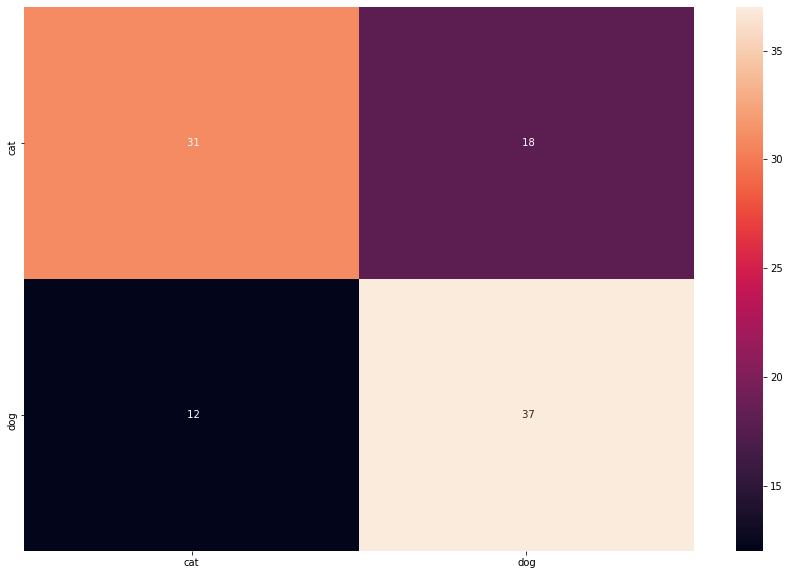

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), fmt='3', annot=True, xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])

In [18]:
print('MCC: {}'.format(matthews_corrcoef(y_true, y_pred)))

MCC: 0.3906951575475158


# Visually Insepct

In [21]:
def load_prepare_wav(wav_path, max_ms=8000):
    sig, sr = torchaudio.load(wav_path)
    resig = torchaudio.transforms.Resample(sr, 44100)(sig[:1, :])
    sr = 44100

    # Convert to 2 channel
    resig = torch.cat([resig, resig])

    # Pad trunc
    num_rows , sig_len = resig.shape
    max_len = sr // 1000 * max_ms

    if sig_len > max_len:
        resig = resig[:, :max_len]
    elif sig_len < max_len:
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = np.random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        resig = torch.cat((pad_begin, resig, pad_end), 1)

    # Convert to mel spectogram
    spec = torchaudio.transforms.MelSpectrogram(
        sr, n_fft=1024, hop_length=None, n_mels=64
    )(resig)
    spec = torchaudio.transforms.AmplitudeToDB(top_db=80)(spec)
    
    return spec

In [22]:
from IPython.display import Audio

In [29]:
wav_file = df[~df['test_cat'].isnull()].sample(1)['test_cat'].iloc[0]
labels = {0: 'cat', 1: 'dog'}

In [30]:
wav_path = os.path.join('data/cats_dogs/', wav_file)

In [31]:
spec = load_prepare_wav(wav_path)

In [32]:
results = model(spec.unsqueeze(0).to('cuda'))

In [33]:
results = F.softmax(results, dim=-1)
results = results.squeeze(0).detach().cpu().numpy()
label = labels[results.argmax()]
print('Label: {}, Conf: {}'.format(label, round(results.max() * 100, 2)))

Label: cat, Conf: 61.24


In [34]:
Audio(wav_path)